# Mushroom Classifier -- Computer Vision with PyTorch

According to [Brandenburg and Ward](https://pubmed.ncbi.nlm.nih.gov/30062915/) (Mycologia, 2018), in the years between 1999 and 2016 there were approximately 7428 cases of mushroom exposure. Mushroom poisoning is remarkably dangerous and enabling foragers to detect the particular species of a mushroom is a powerful tool for ensuring the safety of those who go out into nature and anyone with interests in fungi more broadly.

The aim of the current project is to utilize machine learning frameworks in **PyTorch** in order to implement a **neural network classifier** capable of **computer vision** in order to define the species of mushroom from tensors of pixel data.

Moreover, this project uses **transfer learning** in order to leverage other neural nets trained on image data to create more sophisticated and accurate neural nets than those made from scratch.


<u>Module Imports</u>


In [1]:
import os
import shutil
from PIL import ImageFile

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchinfo import summary
from torchvision import datasets, transforms, models

from utils.utils import (
    pixel_dimension_dataframe,
    plot_mushroom_dimensions_by_class,
    plot_mushroom_class_distribution,
    train_model,
    plot_metrics,
    plot_confusion_matrix,
    plot_multiclass_roc_grid,
    evaluate_on_test,
    measure_inference_time,
    measure_batch_inference_time,
)

access GPU if using a cuda-compatible device, otherwise use the CPU


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Download Data** <br><br>
note: Before you download the dataset to your local machine using the code below. Make sure that you have enough room for 2GB of images.<br>
It seems that the internal structure of the dataset downloads the images twice, and so delete one of the two folders as it is redundant.


In [ ]:
os.makedirs("data", exist_ok=True)
!kaggle datasets download -d maysee/mushrooms-classification-common-genuss-images -p ./data --unzip

In [ ]:
shutil.rmtree("./data/mushrooms")

### Raw Image Dimensions


In [3]:
folder_path = "./data/Mushrooms"
pixel_df = pixel_dimension_dataframe(folder_path)
print(pixel_df)

          class  width  height
0       Boletus    800     533
1       Boletus    800     600
2       Boletus    620     699
3       Boletus    800     600
4       Boletus    637     600
...         ...    ...     ...
6709  Hygrocybe    800     551
6710  Hygrocybe    800     533
6711  Hygrocybe    800     592
6712  Hygrocybe    642     486
6713  Hygrocybe    800     537

[6714 rows x 3 columns]


In [4]:
dimension_stats = pixel_df.describe()
print(dimension_stats)

unique_dims = pixel_df[["width", "height"]].drop_duplicates()
print("Unique image dimensions:", unique_dims)

             width       height
count  6714.000000  6714.000000
mean    796.176795   579.812332
std     132.803124   100.118028
min     259.000000   152.000000
25%     800.000000   533.000000
50%     800.000000   580.000000
75%     800.000000   600.000000
max    1280.000000  1024.000000
Unique image dimensions:       width  height
0       800     533
1       800     600
2       620     699
4       637     600
5       570     427
...     ...     ...
6673    800     868
6681    697     600
6701   1200     924
6706    800     636
6712    642     486

[1330 rows x 2 columns]


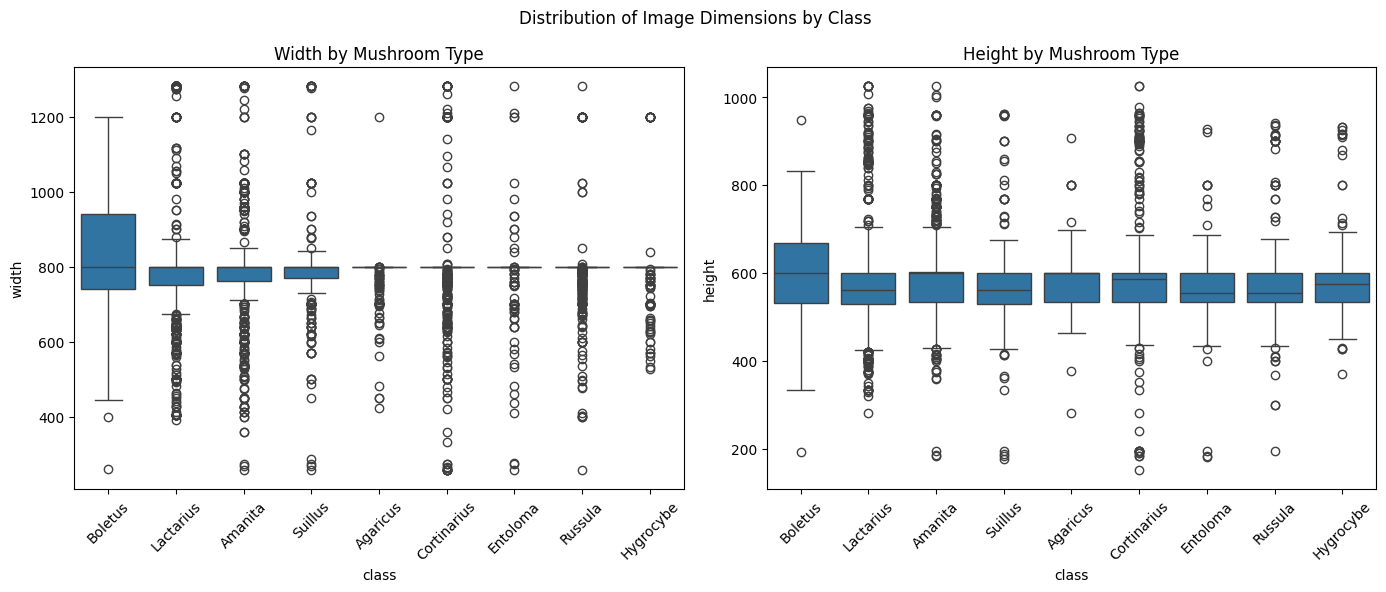

In [5]:
plot_mushroom_dimensions_by_class(pixel_df)

due to the variability in image dimensions, I will later normalize image dimensions.


### How many images are there of each class?


In [6]:
pixel_df["class"].value_counts()

class
Lactarius      1563
Russula        1148
Boletus        1073
Cortinarius     836
Amanita         750
Entoloma        364
Agaricus        353
Hygrocybe       316
Suillus         311
Name: count, dtype: int64

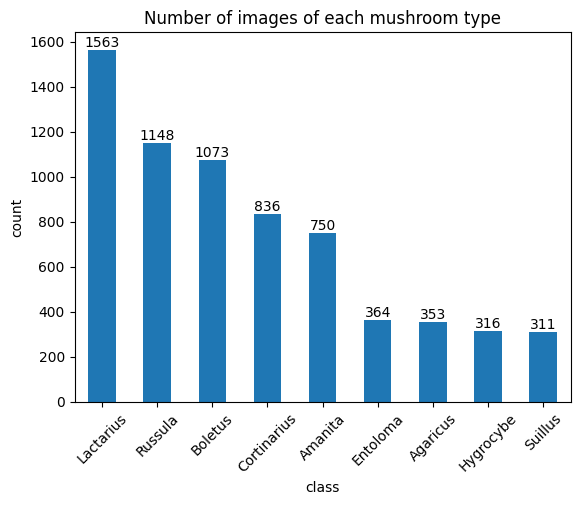

In [7]:
plot_mushroom_class_distribution(pixel_df)

Notice, there is class imbalance. There are over 1000 more examples of Lactarius than Suillus. Moving forward I will perform a train-validation-test splits and sample batches in a weighted way to adress this imbalance.


## Create Tensors from Folder of Images


note: I will choose to process these images the same way that ResNet-18 has been preprocessed according to the [PyTorch documentation](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18)


In [8]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

resize_size = 256
crop_size = 224

train_transform = transforms.Compose(
    [
        transforms.Resize((resize_size, resize_size)),
        transforms.RandomResizedCrop(crop_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

eval_transform = transforms.Compose(
    [
        transforms.Resize((resize_size, resize_size)),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Load dataset
dataset = datasets.ImageFolder(root=folder_path, transform=None)

print(f"Initial Sample Image Dimensions: {dataset[0][0].size}")

Initial Sample Image Dimensions: (778, 600)


What are the class labels?


In [9]:
dataset.class_to_idx

{'Agaricus': 0,
 'Amanita': 1,
 'Boletus': 2,
 'Cortinarius': 3,
 'Entoloma': 4,
 'Hygrocybe': 5,
 'Lactarius': 6,
 'Russula': 7,
 'Suillus': 8}

To later access class names for human-readibility, I will flip this dictionary.


In [10]:
idx_to_class = {idx: class_name for class_name, idx in dataset.class_to_idx.items()}

#### Split the data -- train, validation, test

Although slower than using the PyTorch random_split, I retain the class distribution by using stratification with Scikit-Learn's train_test_split and the Subset object from PyTorch


In [11]:
labels = [label for _, label in dataset]

train_idx, temp_idx = train_test_split(
    range(len(dataset)), test_size=0.4, stratify=labels, random_state=42
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx], random_state=42
)

train_dataset = Subset(dataset, train_idx)
train_dataset.dataset.transform = train_transform

val_dataset = Subset(dataset, val_idx)
val_dataset.dataset.transform = eval_transform

test_dataset = Subset(dataset, test_idx)
test_dataset.dataset.transform = eval_transform

print(
    f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}"
)


Train size: 4028, Validation size: 1343, Test size: 1343


In [12]:
print(f"Processed Sample Image Dimensions: {train_dataset[0][0].size()}")

Processed Sample Image Dimensions: torch.Size([3, 224, 224])


**visualize dataset**


_As Images: This is what we see_


Image Labels, read left to right starting at top left corner: 

Amanita
Boletus
Boletus
Russula
Agaricus
Amanita
Boletus
Russula
Lactarius


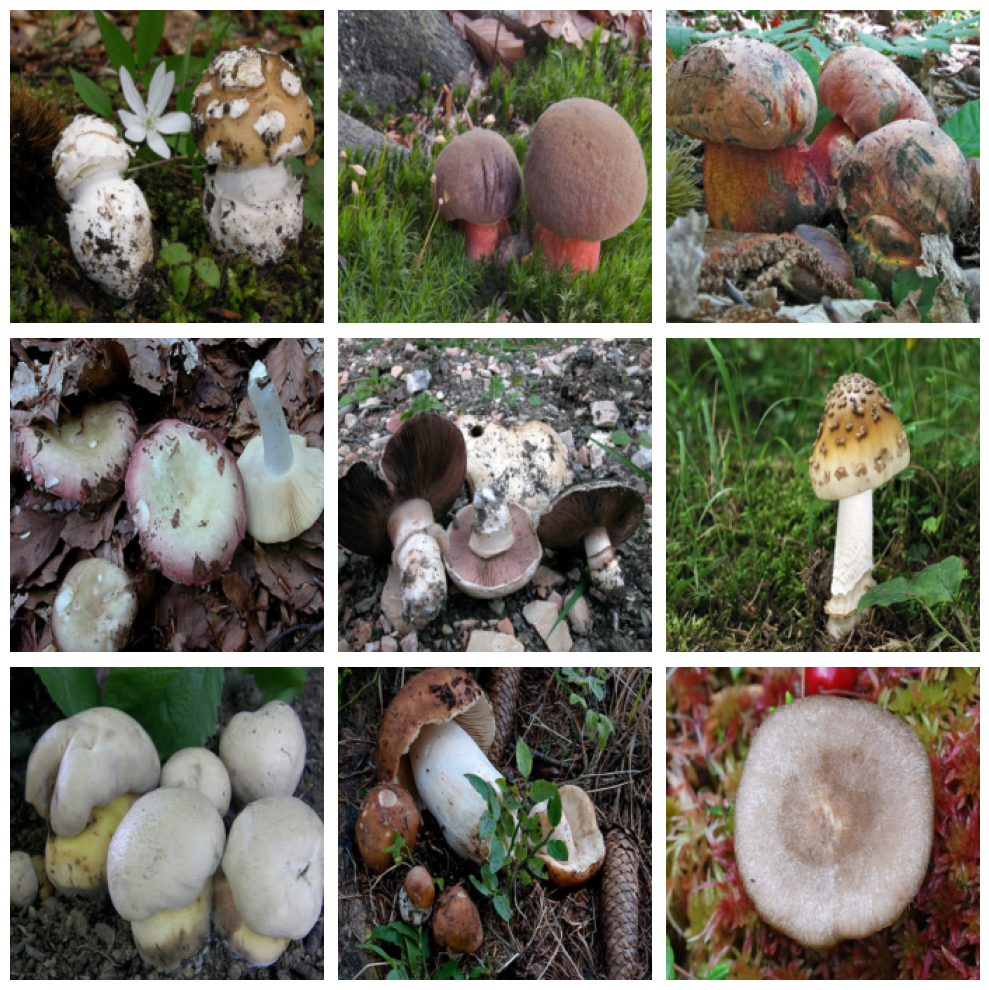

In [13]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

n_rows = 3
n_cols = 3

fig, axarr = plt.subplots(n_rows, n_cols, figsize=(10, 10))
print("Image Labels, read left to right starting at top left corner: \n")
for row in range(n_rows):
    for col in range(n_cols):
        image, label = train_dataset[np.random.randint(0, len(train_dataset))]

        image = image * std[:, None, None] + mean[:, None, None]
        image = torch.clamp(image, 0, 1)

        axarr[row, col].imshow(image.permute(1, 2, 0))
        axarr[row, col].axis("off")
        print(idx_to_class[label])

plt.tight_layout()
plt.show()

_As Tensors: This is what our neural network sees_


In [14]:
subset_item = train_dataset[0]

original_dataset = train_dataset.dataset
original_index = train_dataset.indices[0]

data, label = original_dataset[original_index]

print(f"Data: {data}")
print(f"Label: {label}")

Data: tensor([[[-1.4672, -1.5014, -1.6042,  ..., -1.5357, -1.5014, -1.5185],
         [-1.4500, -1.4158, -1.4843,  ..., -1.5699, -1.5699, -1.6213],
         [-1.3987, -1.3302, -1.3644,  ..., -1.5014, -1.5528, -1.6042],
         ...,
         [-0.2342,  0.1597,  0.4508,  ..., -1.9467, -1.9809, -1.9980],
         [ 0.4679,  0.4851,  0.4679,  ..., -1.9809, -1.9638, -2.0152],
         [ 0.4679,  0.2282,  0.1083,  ..., -1.9809, -1.8953, -1.9809]],

        [[-0.0399, -0.2850, -0.6702,  ..., -1.1604, -1.1604, -1.2129],
         [-0.0749, -0.2675, -0.6352,  ..., -1.1253, -1.1779, -1.2829],
         [-0.1275, -0.2675, -0.5826,  ..., -0.9503, -1.0903, -1.2304],
         ...,
         [-0.8277, -0.7227, -0.6352,  ..., -2.0007, -2.0182, -2.0357],
         [-0.5476, -0.6001, -0.6877,  ..., -2.0182, -2.0007, -2.0007],
         [-0.6176, -0.7752, -0.8277,  ..., -2.0182, -1.9832, -2.0007]],

        [[-1.2467, -1.4384, -1.6476,  ..., -1.5430, -1.5256, -1.4907],
         [-1.2641, -1.4384, -1.6302,  .

#### Prepare DataLoaders


set batch_size parameter


In [15]:
batch_size = 32

In [17]:
class_counts = np.bincount([labels[i] for i in train_idx])
class_weights = 1.0 / class_counts
sample_weights = [class_weights[labels[i]] for i in train_idx]

sampler = WeightedRandomSampler(
    sample_weights, num_samples=len(train_idx), replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Check that Weighted Random Sampler balances the data


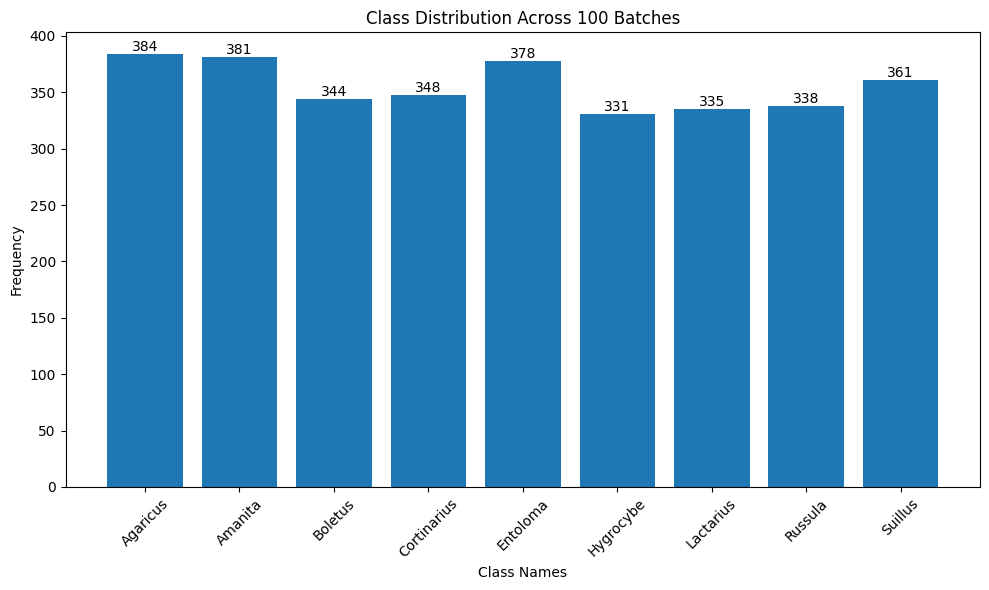

In [18]:
batch_class_counts = {class_name: 0 for class_name in dataset.class_to_idx.keys()}

num_batches_to_check = 100
for i, (images, labels) in enumerate(train_loader):
    if i >= num_batches_to_check:
        break
    batch_labels = [idx_to_class[label.item()] for label in labels]
    for label in batch_labels:
        batch_class_counts[label] += 1

plt.figure(figsize=(10, 6))
bars = plt.bar(batch_class_counts.keys(), batch_class_counts.values(), align="center")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
    )

plt.xlabel("Class Names")
plt.ylabel("Frequency")
plt.title(f"Class Distribution Across {num_batches_to_check} Batches")
plt.xticks(rotation=45, ha="center")
plt.tight_layout()

plt.show()

## Build and Train a Model

**Using Transfer Learning from ResNet Model**


In [19]:
model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
num_classes = len(train_dataset.dataset.classes)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.layer4.parameters():
    param.requires_grad = True

pretrained_model = model.to(device)
summary(pretrained_model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 9]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]   

The summary above allows us to see how much memory is used by the network, what the layers are, and what their tensor sizes and number of parameters are.


**Define training and validation loops**


Define Loss function and optimizer


In [20]:
learn_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, pretrained_model.parameters()), lr=learn_rate
)

In [21]:
epochs = 100

In [22]:
trained_model, metrics = train_model(
    pretrained_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=epochs,
)

Epoch 1/100
----------
Train Loss: 0.7636 Acc: 0.7465
Val Loss: 0.7949 Acc: 0.7401
Epoch 2/100
----------
Train Loss: 0.3336 Acc: 0.8932
Val Loss: 0.6124 Acc: 0.7923
Epoch 3/100
----------
Train Loss: 0.2387 Acc: 0.9243
Val Loss: 0.8453 Acc: 0.7632
Epoch 4/100
----------
Train Loss: 0.1414 Acc: 0.9575
Val Loss: 0.6497 Acc: 0.7990
Epoch 5/100
----------
Train Loss: 0.1154 Acc: 0.9583
Val Loss: 0.7162 Acc: 0.7893
Epoch 6/100
----------
Train Loss: 0.0833 Acc: 0.9719
Val Loss: 0.7739 Acc: 0.7818
Epoch 7/100
----------
Train Loss: 0.0607 Acc: 0.9829
Val Loss: 0.7863 Acc: 0.7997
Epoch 8/100
----------
Train Loss: 0.0737 Acc: 0.9757
Val Loss: 0.8777 Acc: 0.7908
Epoch 9/100
----------
Train Loss: 0.0654 Acc: 0.9786
Val Loss: 0.7862 Acc: 0.8019
Epoch 10/100
----------
Train Loss: 0.0652 Acc: 0.9786
Val Loss: 0.8537 Acc: 0.7856
Epoch 11/100
----------
Train Loss: 0.0491 Acc: 0.9846
Val Loss: 0.8419 Acc: 0.7975
Epoch 12/100
----------
Train Loss: 0.0458 Acc: 0.9844
Val Loss: 0.9088 Acc: 0.8012
E

## Assess the Model


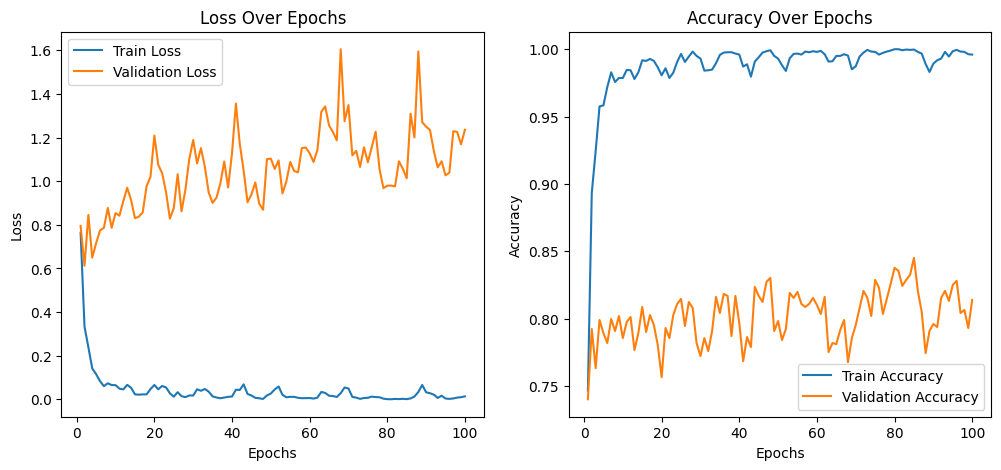

In [30]:
plot_metrics(metrics)

There may be overfitting to the training data since as loss to the training data and training accuracy asymptotes, loss with respect to the validation set appears to creep upwards. This perhaps suggests that some of the training data transformations are not ideal.


In [31]:
summary(trained_model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  (36,864)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  (36,864)
│    │    └─BatchNorm2d: 3-5             (128)
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  (36,864)
│    │    └─BatchNorm2d: 3-7             (128)
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  (36,864)
│    │    └─BatchNorm2d: 3-10            (128)
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11   

**save the model**


In [33]:
torch.save(trained_model.state_dict(), "mushroom_resnet18.pth")
print("Model saved as mushroom_resnet18.pth")

Model saved as mushroom_resnet18.pth


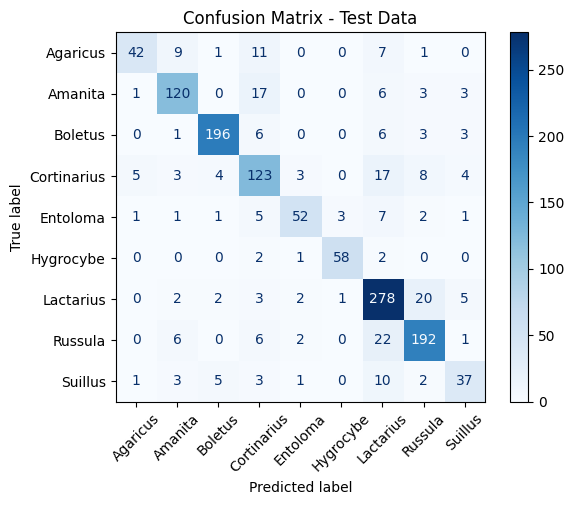

In [32]:
plot_confusion_matrix(
    trained_model,
    test_loader,
    device,
    class_names=train_loader.dataset.dataset.classes,
    title="Confusion Matrix - Test Data",
)

In general, predictions are quite good. However, the model still has room for improvement.


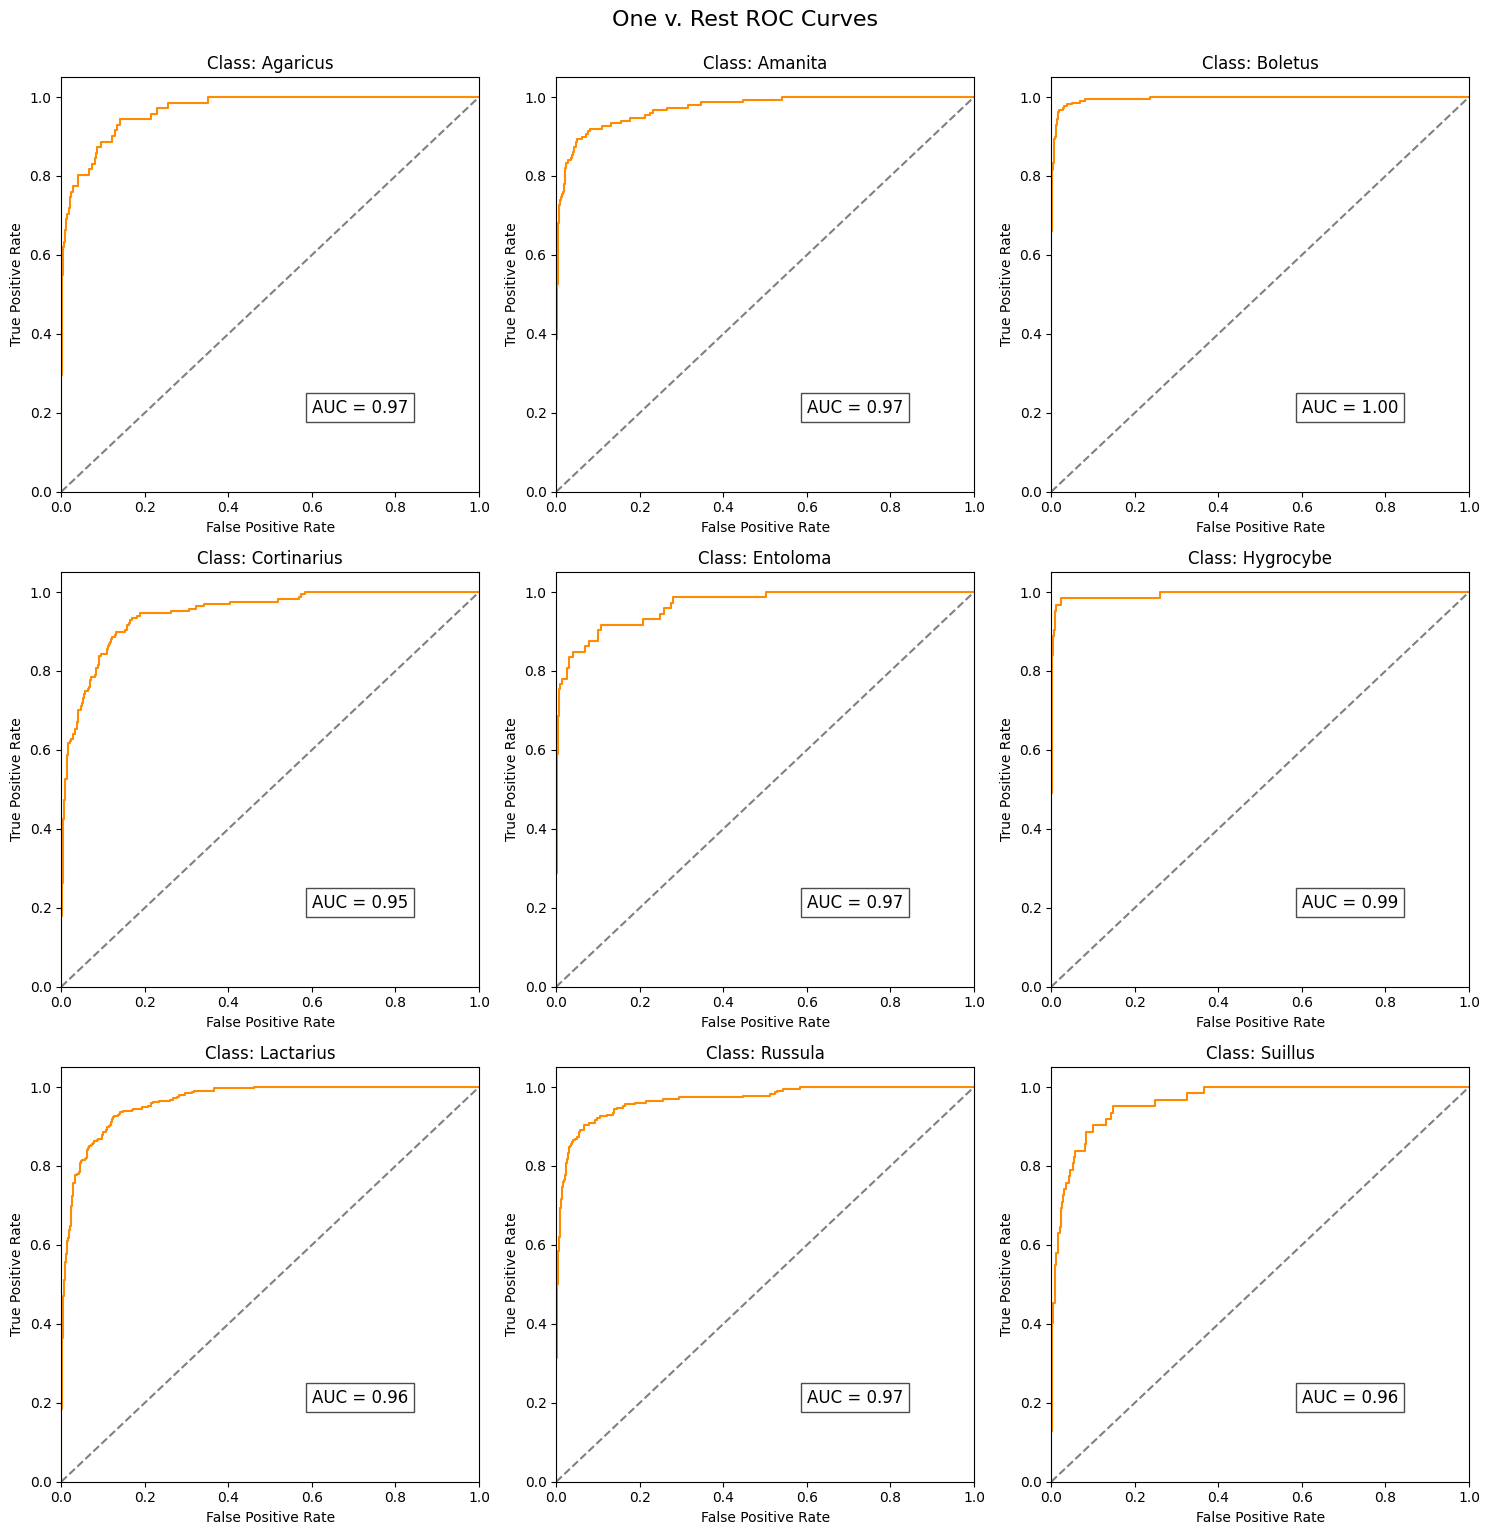

In [34]:
plot_multiclass_roc_grid(
    trained_model, test_loader, train_loader.dataset.dataset.classes, device
)

In [35]:
all_preds, all_labels = evaluate_on_test(trained_model, test_loader, criterion, device)

Test Loss: 1.0847
Test Accuracy: 0.8176


#### Assess model inference speed


for a single observation


In [42]:
input_sample = torch.randn(1, 3, 224, 224).to(device)
measure_inference_time(trained_model, input_sample, device)

Average Inference Time: 2.885 ms


for a single batch of 32 images from the test loader


In [43]:
inputs, _ = next(iter(test_loader))
input_sample = inputs.to(device)
measure_inference_time(trained_model, input_sample, device)

Average Inference Time: 18.211 ms


for a random batch with the same size as 32 images


In [44]:
batch_input_sample = torch.randn(batch_size, 3, 224, 224).to(device)
measure_batch_inference_time(trained_model, batch_input_sample, device)

Average Inference Time: 18.482 ms


# Conclusions and Future Directions

The model that we train here which is created via **transfer learning** using ResNet18 as a backbone appears to be quite capable of predicting the species of mushroom from images beyond baseline. However, it's performance does appear to asymptote at approximately 80% validation accuracy relatively early on, hence methods to prevent overfitting and hyperparameter tuning would likely produce a more performant model.

By using a cuda-compatible GPU, I am able to speed up PyTorch performance and generate a high-performing model relatively quickly.

Some improvements that can be made to the model.

- can optimize hyperparamters such as batch size and learning rate (e.g. using Optuna)
- can run the model for more epochs in order to get an even better performance

Another future direction is to deploy the neural network to an endpoint.
